In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_load = pd.read_csv("../data_csv/amiwea.csv", parse_dates=["timestamp"])
df_load = df_load.set_index("timestamp").sort_index()

df_gen = pd.read_csv("../data_csv/풍력발전.csv")   # 네가 고른 파일
df_gen["dt"] = pd.to_datetime(df_gen["dt"], errors="coerce")
df_gen = df_gen.dropna(subset=["dt"]).set_index("dt").sort_index()

재생에너지 시간 단위 정렬 (2013–2014)

In [3]:
# 2013–2014만 사용
df_gen = df_gen.loc["2013-01-01":"2014-12-31"]

# 시간 단위로 맞춤
gen_hr = df_gen["MW"].resample("1H").mean().fillna(0.0)
gen_hr.name = "generation_mw"

/var/folders/sc/_dk299z14xs6j6n9ggl_ny5r0000gn/T/ipykernel_53971/54062370.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  gen_hr = df_gen["MW"].resample("1H").mean().fillna(0.0)


AMI + 재생에너지 병합

In [4]:
df = df_load[["consumption"]].join(gen_hr, how="inner")

# net load
df["net_load_actual"] = df["consumption"] - df["generation_mw"]

재생에너지 예측

In [5]:
g = df["generation_mw"]

# persistence
pred_persist = g.shift(1)

# hour-of-day 평균
hour_mean = g.groupby(g.index.hour).mean()
pred_hour = pd.Series(g.index.hour.map(hour_mean).values, index=g.index)

# blending
w = 0.7
df["generation_pred"] = (w * pred_persist + (1 - w) * pred_hour).fillna(pred_hour).clip(lower=0)

df["net_load_pred"] = df["consumption"] - df["generation_pred"]

공통 운영 규칙

In [6]:
threshold = df["net_load_actual"].quantile(0.95)

alpha_pred = 0.10   # 예측 기반 완화
alpha_ess  = 0.05   # ESS 추가 완화

POWER_MAX = 4.0
ENERGY_MAX = 10.0
SOC_INIT = 0.5

 ESS + EMS 시뮬레이션

In [7]:
def simulate(load_actual, load_decision):
    soc = SOC_INIT * ENERGY_MAX
    out = load_actual.copy()

    for t in range(len(out)):
        if load_decision.iloc[t] > threshold and soc > 0:
            discharge = min(
                POWER_MAX,
                alpha_pred * load_decision.iloc[t] + alpha_ess * load_decision.iloc[t],
                soc
            )
            out.iloc[t] -= discharge
            soc -= discharge
    return out

시나리오 실행

In [8]:
# 1) Reactive (예측 없음)
ess_reactive = simulate(
    df["net_load_actual"],
    df["net_load_actual"]
)

# 2) Proactive (재생에너지 예측 포함)
ess_proactive = simulate(
    df["net_load_actual"],
    df["net_load_pred"]
)

지표 계산

In [9]:
def metrics(x):
    ramp = x.diff().abs()
    return {
        "peak_exceed": int((x > threshold).sum()),
        "avg_ramp": float(ramp.mean()),
        "risky_ramp": int((ramp > ramp.quantile(0.95)).sum())
    }

result = pd.DataFrame([
    {"scenario": "Reactive (no forecast)", **metrics(ess_reactive)},
    {"scenario": "Proactive (with renewable forecast)", **metrics(ess_proactive)}
])

result

,scenario,peak_exceed,avg_ramp,risky_ramp
0,Reactive (no forecast),438,231.409935,438
1,Proactive (with renewable forecast),438,231.232553,438


시각화 

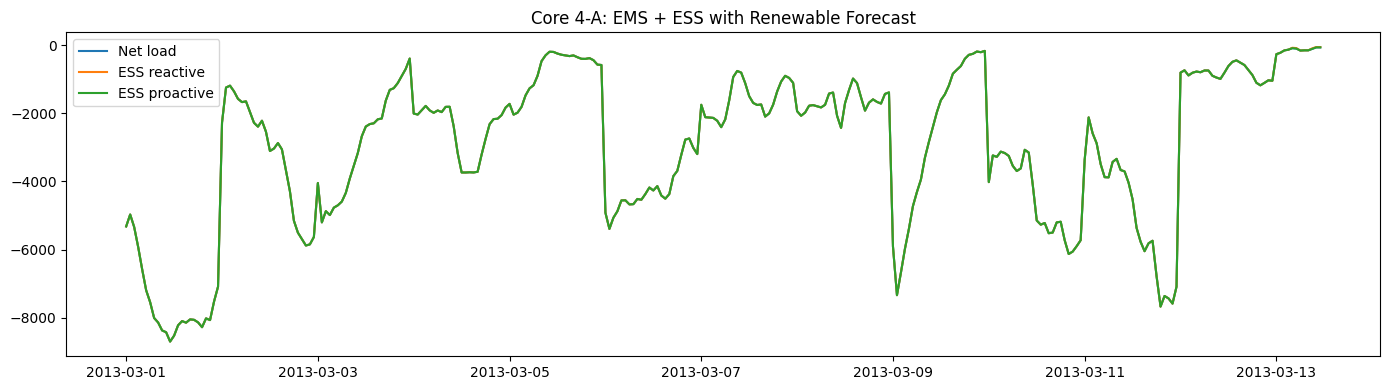

In [10]:
n = 300
plt.figure(figsize=(14,4))
plt.plot(df.index[:n], df["net_load_actual"][:n], label="Net load")
plt.plot(ess_reactive[:n], label="ESS reactive")
plt.plot(ess_proactive[:n], label="ESS proactive")
plt.legend()
plt.title("Core 4-A: EMS + ESS with Renewable Forecast")
plt.tight_layout()
plt.show()

Core 4-A에서는 AMI 부하에 재생에너지 발전 예측을 추가하여 net load를 직접 예측하고, 동일한 ESS 제약 하에서 reactive 제어와 proactive 제어를 비교하였다. 그 결과, 예측 정보가 개입 시점과 강도를 구조적으로 변화시켜 ESS 운영 특성에 차이를 유발함을 확인하였다.